In [114]:
%matplotlib inline

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython import display

In [115]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [116]:
torch.manual_seed(239)
np.random.seed(239)

In [117]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [118]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [119]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [120]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [121]:
######################

In [122]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [123]:
dictionary = make_dictionary(all_codones)

In [124]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [125]:
######################

In [126]:
class SkipGramModel(nn.Module):
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.u_embeddings = nn.Embedding(vocab_size, embed_size, sparse=True)   
        self.v_embeddings = nn.Embedding(vocab_size, embed_size, sparse=True) 
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        initrange = 0.5 / self.embed_size
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(0, 0)

    def forward(self, u_pos, v_pos, v_neg):
        embed_u = self.u_embeddings(u_pos)
        embed_v = self.v_embeddings(v_pos)

        score = torch.sum(torch.mul(embed_u, embed_v), dim=1)
        log_target = F.logsigmoid(score).squeeze()

        neg_embed_v = self.v_embeddings(v_neg)
        neg_score = torch.sum(torch.bmm(neg_embed_v, embed_u.unsqueeze(2)).squeeze(), dim=1)
        sum_log_sampled = F.logsigmoid(-neg_score).squeeze()

        return -(log_target.sum() + sum_log_sampled.sum()) / BATCH_SIZE

In [270]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .03
NUM_TRAIN_STEPS = 200000
SKIP_STEP = 1000

In [271]:
def visualize(acc):
    plt.clf()
    plt.plot(acc)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    plt.ylabel('Average loss')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [272]:
all_loss = np.zeros(NUM_TRAIN_STEPS // SKIP_STEP)

def train_model(model):
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    total_loss = 0.0
    cnt = 0
    for index in range(NUM_TRAIN_STEPS):
        u_pos, v_pos = next(batch_gen)
        v_neg = np.random.choice(VOCAB_SIZE, size=(BATCH_SIZE, NUM_SAMPLED))

        optimizer.zero_grad()
        loss = model.forward(torch.tensor(u_pos, dtype=torch.long), 
                             torch.tensor(v_pos, dtype=torch.long), 
                             torch.tensor(v_neg, dtype=torch.long))
        if index < NUM_TRAIN_STEPS // 2 or cnt == 0 or loss < all_loss[index // SKIP_STEP // 2]:
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            cnt += 1

        if index % SKIP_STEP == SKIP_STEP - 1:
            all_loss[index // SKIP_STEP] = total_loss / cnt
            visualize(all_loss)
            total_loss = 0.0
            cnt = 0
    return model.u_embeddings.weight.data.numpy()

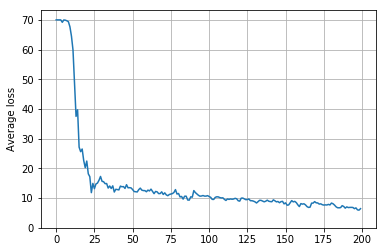

In [273]:
model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE)
final_embed_matrix = train_model(model)
visualize(all_loss)
plt.clf()

In [274]:
######################

In [275]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [276]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,13.976973,6.440463,LHQ
1,-20.875153,-59.820755,HAQ
2,8.855751,12.876949,EYS
3,-35.749016,-27.458433,AKN
4,-58.858543,-20.725256,GIL


In [277]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

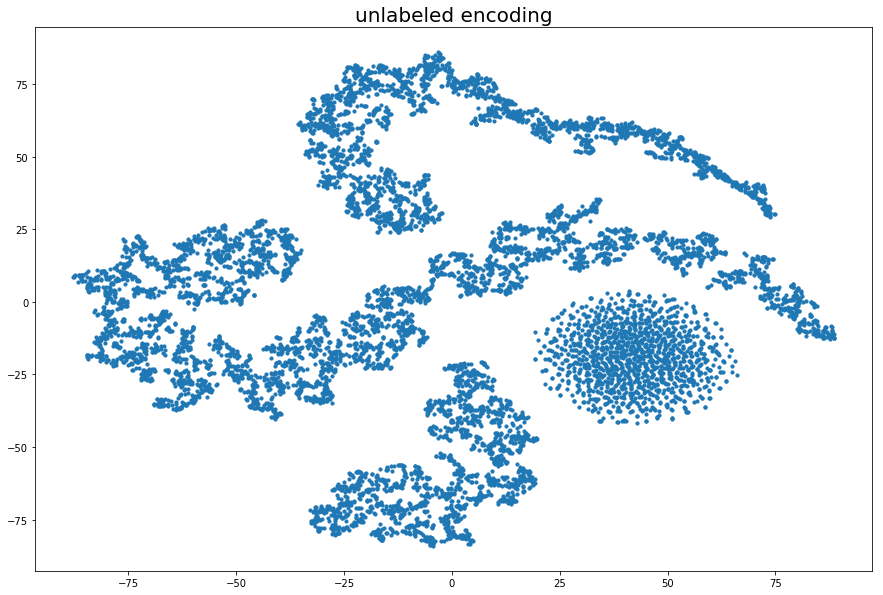

In [278]:
plot_tsne_df(tsne_df)

In [279]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [280]:
######################

In [281]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [282]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [283]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,LHQ,-0.966667,126.142033,20.666667,154.566667
1,HAQ,-1.633333,112.115467,17.666667,128.533333
2,EYS,-1.866667,126.454867,19.000000,140.333333
3,AKN,-1.866667,104.450933,18.000000,123.766667
4,GIL,2.633333,94.455500,18.000000,131.166667


In [284]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,LHQ,-0.966667,126.142033,20.666667,154.566667,13.976973,6.440463
1,HAQ,-1.633333,112.115467,17.666667,128.533333,-20.875153,-59.820755
2,EYS,-1.866667,126.454867,19.000000,140.333333,8.855751,12.876949
3,AKN,-1.866667,104.450933,18.000000,123.766667,-35.749016,-27.458433
4,GIL,2.633333,94.455500,18.000000,131.166667,-58.858543,-20.725256


In [285]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

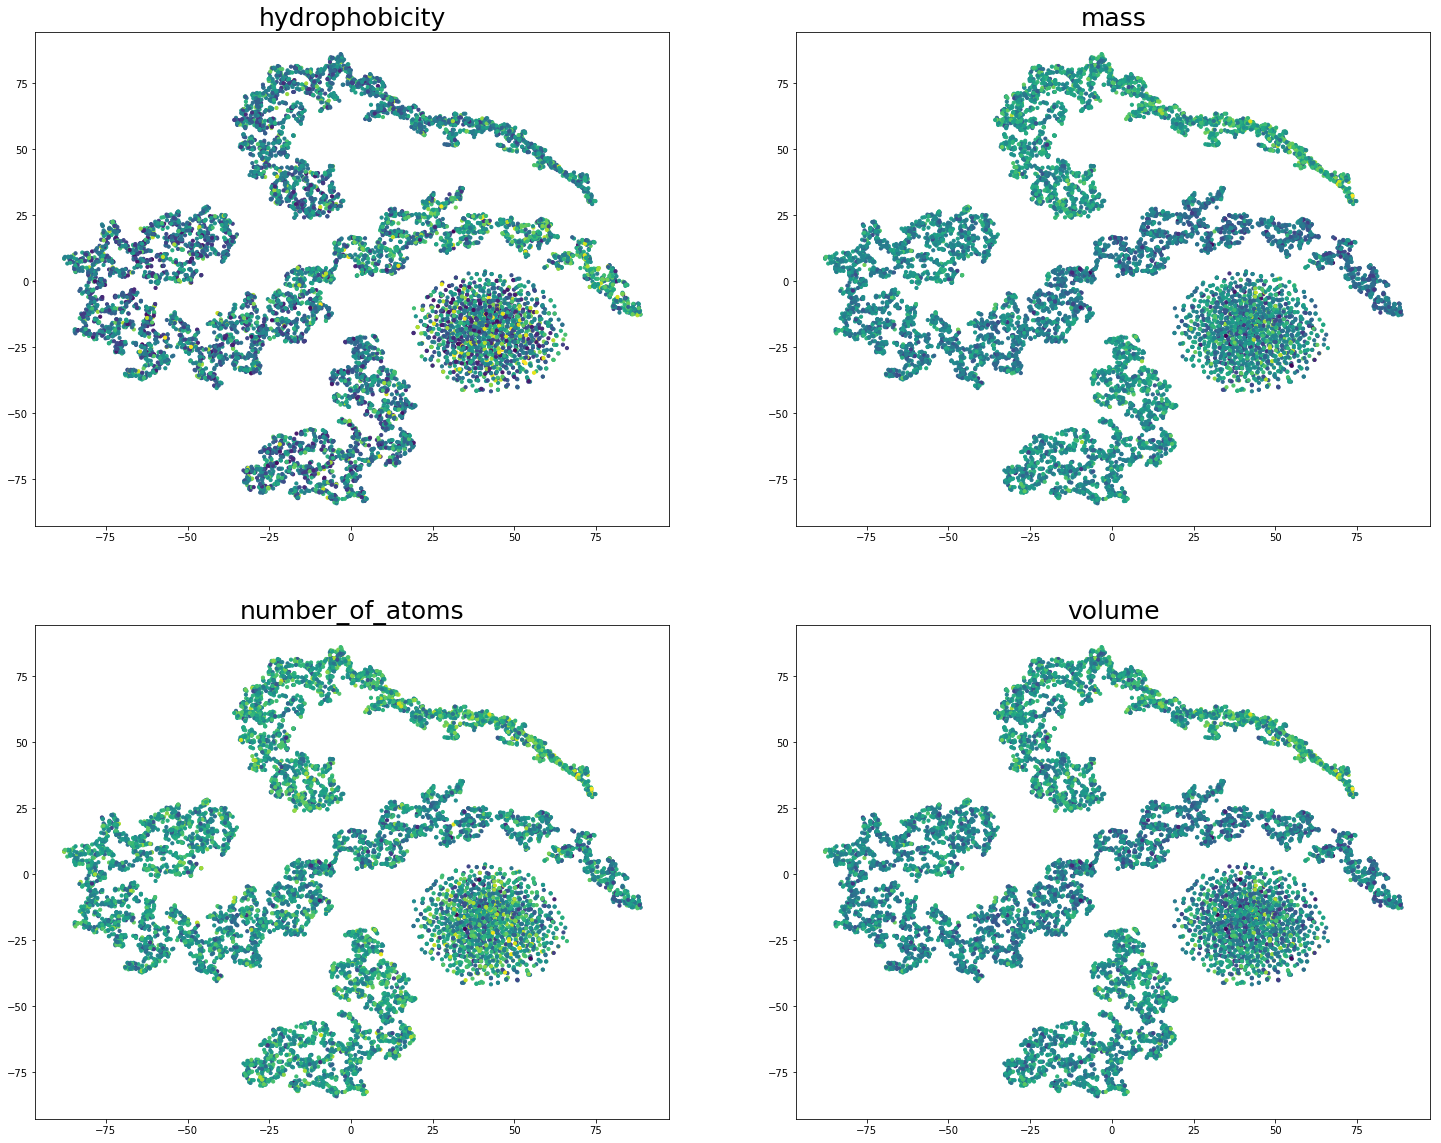

In [286]:
plot_embedding_properties(final_df)

In [235]:
######################

In [236]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

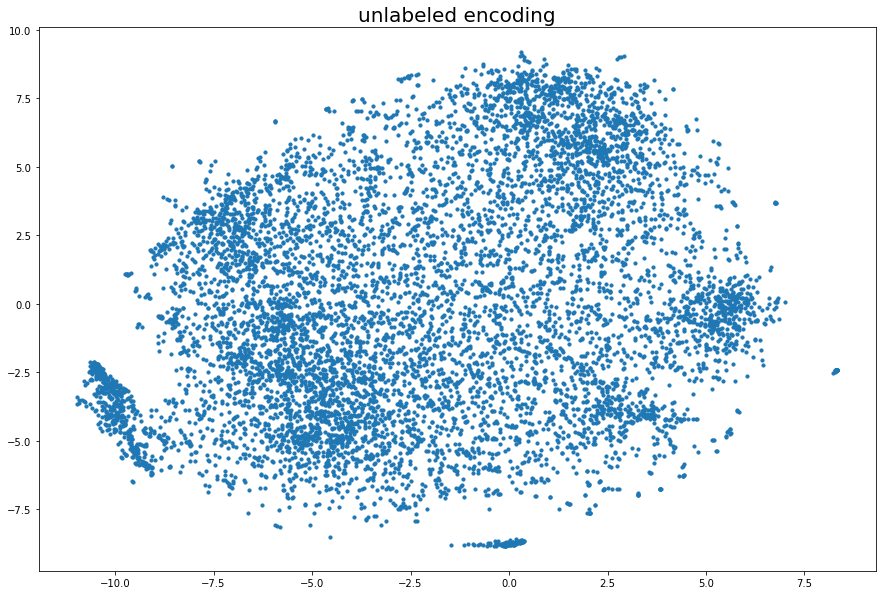

In [237]:
plot_tsne_df(gensim_tsne_df)

In [238]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

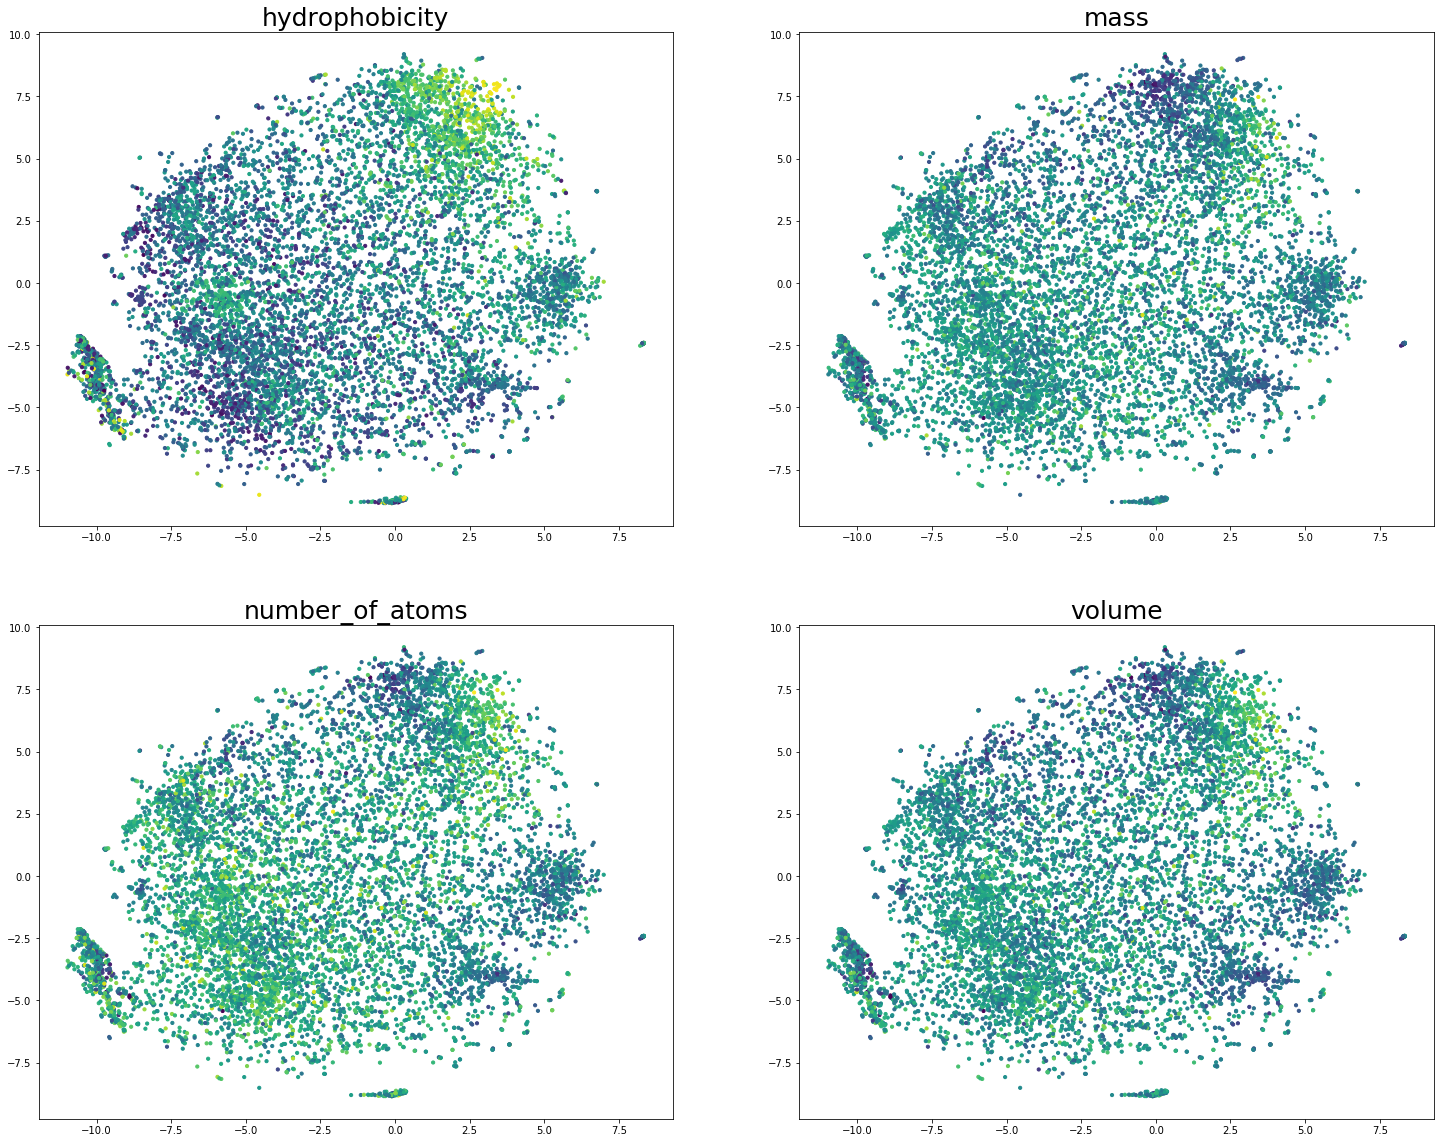

In [239]:
plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59